# PART 1 - INITIALIZE

## Import packages

In [52]:
# %reset -f # Clear all variables

# LINC API
import hackathon_linc as lh
lh.init('92438482-5598-4e17-8b34-abe17aa8f598') # Authenticate and connect to API

# For data handling
import pandas as pd
import numpy as np
from datetime import datetime, time

# For plotting
import hvplot.pandas
import holoviews as hv

# For shared data
import shared

# Miscellaneous
import sys
import os
from functions.metrics import calculate_rsi, calculate_moving_average, calculate_moving_std



    Welcome to the LINC Hackathon! Your token is now saved in the Console. 
    That means you don't need to carry that out when using the other functions
    as long as you don't close your console. 
    
    This function is only to be used once to authenticate your token.
    
    Happy coding!

    


In [40]:
# Fetch starting balance
start_balance = lh.get_balance()
print(f"Starting balance: {start_balance}")

Starting balance: 1001181.47


## Save data to shared (for testing)

In [33]:
CSV_file_path = 'stockPrices_hourly.csv' 

# Read historical data
df = pd.read_csv(f'historical_data/{CSV_file_path}')


# Add date column and convert date columns to datetime
df['gmtTime'] = pd.to_datetime(df['gmtTime'])
df['date'] = pd.to_datetime(df['gmtTime'].dt.date)

# Add averaged price and volume columns
df['price'] = (df['askMedian'] + df['bidMedian']) / 2

# Sort values
df = df.sort_values(by=['symbol', 'gmtTime'])

# **Maintain rolling window**
max_rows = np.inf
if len(df) > max_rows:
    df = df.iloc[-max_rows:]  # Keep only last max_rows entries

# Aggregate daily open and close prices (assumes historical data contains full days)
df_daily = df.groupby(['symbol', 'date']).agg(
    openPrice=('price', 'first'),  # First price of the day
    closePrice=('price', 'last'),  # Last price of the day
    askVolume=('askVolume', 'sum'), # Sum ask volume over the entire day
    bidVolume=('bidVolume', 'sum') # Sum bid volume over the entire day
).reset_index()

# Sort values
df_daily = df_daily.sort_values(by=['symbol', 'date'])

# **Save dataframes to shared data**
shared.shared_data['df'] = df
shared.shared_data['df_daily'] = df_daily

print(f"Columns in hourly DataFrame: {list(shared.shared_data['df'].columns)}")
print(f"Columns in daily DataFrame: {list(shared.shared_data['df_daily'].columns)}")
print(f"Stocks: {list(shared.shared_data['df']['symbol'].unique())}")
print("------Hourly DataFrame------")
shared.shared_data['df_daily'].head()

Columns in hourly DataFrame: ['gmtTime', 'askMedian', 'bidMedian', 'askVolume', 'bidVolume', 'spreadMedian', 'symbol', 'date', 'price']
Columns in daily DataFrame: ['symbol', 'date', 'openPrice', 'closePrice', 'askVolume', 'bidVolume']
Stocks: ['STOCK1', 'STOCK10', 'STOCK2', 'STOCK3', 'STOCK4', 'STOCK5', 'STOCK6', 'STOCK7', 'STOCK8', 'STOCK9']
------Hourly DataFrame------


,symbol,date,openPrice,closePrice,askVolume,bidVolume
0,STOCK1,2015-04-22,75.044183,74.614952,3463.198384,3029.416667
1,STOCK1,2015-04-23,74.012842,73.083283,3647.883330,3160.283333
2,STOCK1,2015-04-24,73.969575,74.442367,3400.016668,2829.133333
3,STOCK1,2015-04-27,74.574558,76.217919,2875.623656,2411.539787
4,STOCK1,2015-04-28,76.372558,76.192233,2067.436780,1647.533333


# Calculate hourly daily and percentage change

In [ ]:
df['pct_change'] = df['price'].pct_change(periods=1)
df_daily['pct_change'] = (df_daily['close_price'] - df_daily['open_price']) / df_daily['open_price'] * 100

# PART 2: STRATEGY

## Markowitz optimal portfolio 
$$
\max_\omega \; \omega^\top \mu - \lambda \omega^\top \Sigma \omega \\
\sum \omega_i = 1 \\
\omega_i \geq 0
$$

## Calculate $\mu$ and $\Sigma$

In [50]:
# Calculate log returns
df_daily['log_return'] = df_daily.groupby('symbol', group_keys=False)['openPrice'].transform(lambda x: np.log(x / x.shift(1)))
df_daily.dropna(inplace=True)

# Pivot table to get returns in matrix form (rows = dates, cols = assets)
returns_df = df_daily.pivot(index='date', columns='symbol', values='log_return')

# Compute mean returns and covariance matrix
mu = returns_df.mean().values  # Expected returns (mean of each column)
Sigma = returns_df.cov().values  # Covariance matrix

print(list(returns_df.columns))

['STOCK1', 'STOCK10', 'STOCK2', 'STOCK3', 'STOCK4', 'STOCK5', 'STOCK6', 'STOCK7', 'STOCK8', 'STOCK9']


## Solve optimization problem

In [51]:
from scipy.optimize import minimize

# Risk aversion parameter (adjust as needed)
lambda_ = 0.5  # Higher value means more risk aversion

# Number of assets
n_assets = len(mu)

# Initial guess: Equal weights
w0 = np.ones(n_assets) / n_assets  

# Constraints: Sum of weights = 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds: Ensure weights are non-negative (no short selling)
bounds = [(0, 1)] * n_assets

# Define the objective function to minimize (negative of our function)
def objective(w, mu, Sigma, lambda_):
    return - (np.dot(w, mu) - lambda_ * np.dot(w.T, np.dot(Sigma, w)))

# Solve the optimization
result = minimize(objective, w0, args=(mu, Sigma, lambda_), 
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimal weights
optimal_weights = result.x

print("Optimal Portfolio Weights:", optimal_weights)


Optimal Portfolio Weights: [5.11060295e-01 1.08853898e-16 9.36750677e-17 0.00000000e+00
 5.98479599e-17 2.29850861e-16 2.42861287e-16 2.04644316e-01
 2.84295390e-01 1.73472348e-16]


In [36]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Sample df_daily (ensure it has 'date', 'symbol', and 'log_return' columns)
# df_daily = ...

# Set up rolling window parameters
window_size = 252  # Use past 252 days for each optimization
rebalance_freq = 30  # Re-optimize every 30 days

# Get unique sorted dates
dates = sorted(df_daily['date'].unique())

# Initialize dictionary to store optimal weights over time
portfolio_weights = {}

# Define Markowitz objective function
def markowitz_objective(w, mu, Sigma, lambda_):
    return - (np.dot(w, mu) - lambda_ * np.dot(w.T, np.dot(Sigma, w)))

# Iterate over rolling windows
for i in range(window_size, len(dates), rebalance_freq):
    start_date = dates[i - window_size]
    end_date = dates[i]
    
    # Get data for the rolling window
    df_window = df_daily[(df_daily['date'] >= start_date) & (df_daily['date'] < end_date)]
    
    # Compute expected returns (mean log returns per stock)
    mu = df_window.groupby('symbol')['log_return'].mean().values
    
    # Compute covariance matrix of log returns
    Sigma = df_window.pivot(index='date', columns='symbol', values='log_return').cov().values
    
    # Number of stocks
    num_assets = len(mu)
    
    # Initial weights (equal allocation)
    w0 = np.ones(num_assets) / num_assets

    # Bounds (weights between 0 and 1)
    bounds = [(0, 1) for _ in range(num_assets)]

    # Constraint: Sum of weights must be 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

    # Solve the optimization
    result = minimize(markowitz_objective, w0, args=(mu, Sigma, 0.5), 
                      method='SLSQP', bounds=bounds, constraints=constraints)

    # Store optimal weights
    portfolio_weights[end_date] = result.x

    print(f"Optimized portfolio on {end_date}: {result.x}")

# Convert results to DataFrame
df_portfolio_weights = pd.DataFrame.from_dict(portfolio_weights, orient='index')

print("\nFinal Portfolio Weights over time:")
print(df_portfolio_weights)


Optimized portfolio on 2016-04-21 00:00:00: [1.00000000e+00 4.63171168e-16 0.00000000e+00 6.93889390e-18
 3.59087760e-16 8.67361738e-18 1.28369537e-16 0.00000000e+00
 0.00000000e+00 1.30104261e-16]
Optimized portfolio on 2016-06-03 00:00:00: [1.00000000e+00 6.07153217e-18 0.00000000e+00 0.00000000e+00
 2.35922393e-16 2.04263689e-16 0.00000000e+00 2.15105711e-16
 0.00000000e+00 8.93382590e-17]
Optimized portfolio on 2016-07-15 00:00:00: [1.00000000e+00 6.41847686e-17 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.96782694e-16 5.37764278e-17 2.77555756e-16
 1.49186219e-16 0.00000000e+00]
Optimized portfolio on 2016-08-26 00:00:00: [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.73472348e-17 0.00000000e+00 2.08166817e-17
 0.00000000e+00 0.00000000e+00]
Optimized portfolio on 2016-10-10 00:00:00: [1.00000000e+00 0.00000000e+00 2.41126563e-16 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.03576608e-17 1.66533454e-16
 7.71951947e-17 1.21430643e-17]
Optimized 

## See performance

Final Portfolio Value: $100,000.00
Percentage gain: 0.00%


<Axes: title={'center': 'Portfolio Value Over Time'}>

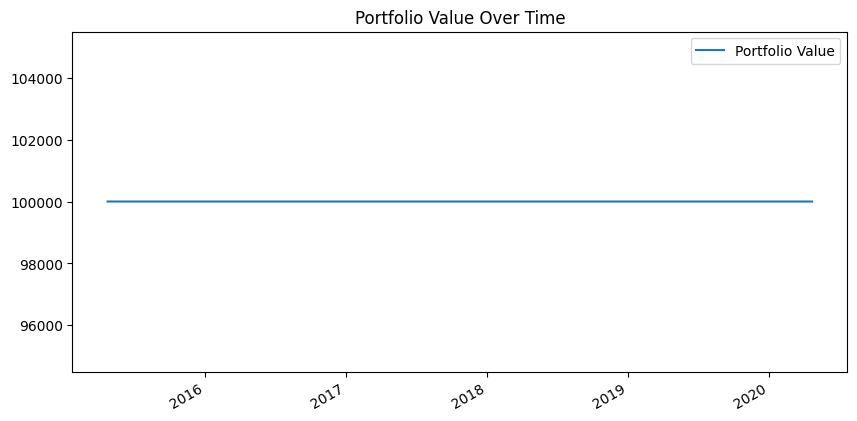

In [45]:
# Assume `df_portfolio_weights` contains portfolio weights indexed by rebalance date
# Assume `df_daily` contains 'date', 'symbol', and 'log_return' columns

# Set initial balance
initial_balance = 100000  # Start with $100,000

# Get sorted unique dates
dates = sorted(df_daily['date'].unique())

# Convert portfolio weights DataFrame to a dictionary for easy lookup
portfolio_weights_dict = df_portfolio_weights.to_dict(orient='index')

# Convert all rebalance dates and df_daily dates to datetime
portfolio_weights_dict = {pd.to_datetime(k): v for k, v in portfolio_weights_dict.items()}
dates = pd.to_datetime(dates)


# Initialize portfolio value tracking
portfolio_value = {dates[0]: initial_balance}
portfolio_returns = []

# Iterate over dates to compute returns
for i in range(1, len(dates)):
    current_date = dates[i]
    prev_date = dates[i-1]

    # Find the most recent rebalance date
    valid_rebalance_dates = [d for d in portfolio_weights_dict.keys() if d <= prev_date]

    if valid_rebalance_dates:
        last_rebalance_date = max(valid_rebalance_dates)
    else:
        print(f"Warning: No rebalance date found before {prev_date}. Using first available.")
        last_rebalance_date = min(portfolio_weights_dict.keys())  # Use first rebalance date as fallback

    weights = np.array(list(portfolio_weights_dict[last_rebalance_date].values()))

    # Get stock returns for current day
    daily_returns = df_daily[df_daily['date'] == current_date].set_index('symbol')['log_return']

    # Ensure stock order matches weights order
    daily_returns = daily_returns.reindex(df_portfolio_weights.columns).fillna(0).values

    # Compute portfolio return for the day
    portfolio_return = np.dot(weights, daily_returns)
    portfolio_returns.append(portfolio_return)

    # Compute new portfolio value
    portfolio_value[current_date] = portfolio_value[prev_date] * np.exp(portfolio_return)

# Convert portfolio values to DataFrame
df_portfolio_value = pd.DataFrame.from_dict(portfolio_value, orient='index', columns=['Portfolio Value'])

# Print final portfolio value
print(f"Final Portfolio Value: ${df_portfolio_value.iloc[-1, 0]:,.2f}")
print(f"Percentage gain: {(df_portfolio_value.iloc[-1, 0] - initial_balance)/ initial_balance:.2f}%")

# Display portfolio value over time
df_portfolio_value.plot(title="Portfolio Value Over Time", figsize=(10, 5))


In [ ]:
# Initialize variables
symbols = list(df['symbol'].unique()) # List of all symbols
nbr_stocks = len(symbols)
cash_capital = start_balance 
start_capital = cash_capital
barrier_capital = cash_capital
holding_period_days = 20
cool_down_period = 8*10 #10

current_position = {symbol: False for symbol in symbols} # 1x10 vektor: 1 om en position finns, 0 annars
current_time = np.zeros(nbr_stocks) # 1xn vektor: senaste indexet för när ett köp gjordes
cant_buy_timer = np.zeros(nbr_stocks) # 1xn vektor: här sparas indexet för då senaste stoppen togs
last_payed = np.zeros(nbr_stocks) # 1xn vektor: dummy-vektor för senaste priset
buy_price = np.zeros(nbr_stocks) # 1xn vektor: senaste priset för när ett köp gjordes
sell_price = np.zeros(nbr_stocks) # 1xn vektor: senaste priset för när ett sälj gjordes
number_stocks = np.zeros(nbr_stocks) # 1xn vektor: antalet aktier vi äger i en enskild aktie

PnL_matrix = np.zeros((len(all_1h_data),hist_stocks))
market_regim = []
nr_loss_trades = []
nr_profit_trades = []
avr_loss_trades = []
avr_profit_trades = []

# Tar fram startvärde
all_1h_data['date'] = pd.to_datetime(all_1h_data['date'])
start_date = pd.to_datetime(all_EOD_data['date'].iloc[0]).normalize()
matching_rows = all_1h_data[all_1h_data['date'].dt.normalize() == start_date]
start_index = matching_rows.index.min()
save_index = start_index

print("Backtesting, trade log:")

# Kör igenom i tissteget
for index in range(start_index, len(all_1h_data)): 

    # Tar fram gårdagens datum och mapar mot EOD-datan
    previous_date = pd.to_datetime(all_1h_data['date'].iloc[index-9]).normalize()
    previous_EOD_row = all_EOD_data[all_EOD_data['date'].dt.normalize() == previous_date]

    stock_counter = 0
    
    # Regimfilter
    for i in range(hist_stocks):
        
        previous_EOD_price = previous_EOD_row.iloc[0,1+4*i]
        previous_EOD_MA63 = previous_EOD_row.iloc[0,2+4*i]
        previous_EOD_MA252 = previous_EOD_row.iloc[0,3+4*i]

        if previous_EOD_MA63 > previous_EOD_MA252:
            stock_counter = stock_counter+1

    market_breadth = stock_counter/hist_stocks
    regim_condition = 0.4 # 0.4

    if market_breadth >= regim_condition:
        market_regim.append(1)
        current_regim = 1
    else:
        market_regim.append(0)
        current_regim = 0
    
    number_trades = 0
    add_cash = np.zeros(hist_stocks)

    # Kör igenom varje aktie för samma tidssteg
    for i in range(hist_stocks):

        # För underliggande momentumvillkor
        previous_EOD_price = previous_EOD_row.iloc[0,1+4*i]
        previous_EOD_MA63 = previous_EOD_row.iloc[0,2+4*i]
        previous_EOD_MA252 = previous_EOD_row.iloc[0,3+4*i]
        previous_EOD_STD63 = previous_EOD_row.iloc[0,4+4*i]

        # Tillbakablicksperiod för pris och RSI
        start_index = index-30
        end_index = index-10

        # För prisvillkor
        current_1h_price = all_1h_data.iloc[index,1+2*i]
        lowest_1h_price = all_1h_data.iloc[start_index:end_index,1+2*i].min()

        # För RSI-villkor
        current_1h_RSI = all_1h_data.iloc[index,2+2*i]
        lowest_1h_RSI = all_1h_data.iloc[start_index:end_index,2+2*i].min()
    
        # Justerbara värden
        RSI_threshold = 50
        std_threshold = 1.0 # 1.0

        # Köpvillkor
        if current_regim == 1 and index > cant_buy_timer[i]+cool_down_period and current_position[i] == 0 and current_1h_RSI < RSI_threshold and current_1h_RSI > lowest_1h_RSI and current_1h_price < lowest_1h_price and previous_EOD_price > previous_EOD_MA63 and previous_EOD_MA63 > previous_EOD_MA252:
            current_time[i] = index
            last_payed[i] = current_1h_price
            number_trades = number_trades+1

        # Risk management-sälj
        elif current_position[i] == 1 and (current_1h_price/buy_price[i])-1 < -std_threshold*previous_EOD_STD63:
            PnL_matrix[index,i] = (current_1h_price-buy_price[i])*number_stocks[i]
            add_cash[i] = current_1h_price*number_stocks[i]
            sell_amount = current_1h_price*number_stocks[i]
            date_object = pd.to_datetime(all_1h_data['date'].iloc[index])
            print(f"Risk management: Sold for {sell_amount:.0f}$ in stock_{i} for price {current_1h_price:.2f} at time {date_object} with {index}")
            number_stocks[i] = 0
            current_position[i] = 0
            cant_buy_timer[i] = index
            nr_loss_trades.append(1)
            avr_loss_trades.append(current_1h_price/buy_price[i]-1)

        # Vinsthemtagning-sälj
        elif current_position[i] == 1 and index-current_time[i] > holding_period:
            PnL_matrix[index,i] = (current_1h_price-buy_price[i])*number_stocks[i]
            add_cash[i] = current_1h_price*number_stocks[i]
            sell_amount = current_1h_price*number_stocks[i]
            date_object = pd.to_datetime(all_1h_data['date'].iloc[index])
            print(f"Profit-taking: Sold for {sell_amount:.0f}$ in stock_{i} for price {current_1h_price:.2f} at time {date_object} with {index}")
            number_stocks[i] = 0
            current_position[i] = 0
            nr_profit_trades.append(1)
            avr_profit_trades.append(current_1h_price/buy_price[i]-1)
            
    if cash_capital > 0.01*barrier_capital and number_trades > 0:
        bet_size = cash_capital/number_trades
        for i in range(hist_stocks):
            if current_time[i] == index:
                buy_price[i] = last_payed[i]
                number_stocks[i] = bet_size/buy_price[i]
                current_position[i] = 1
                date_object = pd.to_datetime(all_1h_data['date'].iloc[index])
                print(f"Bought for {bet_size:.0f}$ in stock_{i} for price {buy_price[i]:.2f} at time {date_object} with {index}")
        cash_capital = 0  
        
    cash_capital = cash_capital+sum(add_cash)


Backtesting, trade log:
Bought for 1000000$ in stock_0 for price 109.29 at time 2016-05-13 09:00:00 with 2364
Profit-taking: Sold for 1056639$ in stock_0 for price 115.48 at time 2016-05-27 09:00:00 with 2445
Bought for 1056639$ in stock_0 for price 115.24 at time 2016-05-31 13:00:00 with 2467
Profit-taking: Sold for 1088908$ in stock_0 for price 118.76 at time 2016-06-13 13:00:00 with 2548
Bought for 544454$ in stock_0 for price 117.98 at time 2016-06-13 15:00:00 with 2550
Bought for 544454$ in stock_8 for price 91.97 at time 2016-06-13 15:00:00 with 2550
Risk management: Sold for 536610$ in stock_8 for price 90.65 at time 2016-06-14 07:00:00 with 2551
Bought for 536610$ in stock_6 for price 12.61 at time 2016-06-14 10:00:00 with 2554
Risk management: Sold for 537206$ in stock_0 for price 116.41 at time 2016-06-14 11:00:00 with 2555
Risk management: Sold for 528593$ in stock_6 for price 12.42 at time 2016-06-16 11:00:00 with 2573
Bought for 1065799$ in stock_5 for price 100.12 at time

*SAMMANSTÄLLNING*
Totalavkastning för strategin: 44.65%
Totalavkastning för marknaden: -7.12%
Genomsnittlig årlig avkastning för strategin: 6.70%
Antal vinsttrades: 51
Antal förlusttrades: 85
Vinstsannolikhet: 37.50%
Förlustsannolikhet: 62.50%
Genomsnittlig vinsttrade: 3.34%
Genomsnittlig förlusttrade: -1.65%
Vinst/förlust-ratio: 2.03


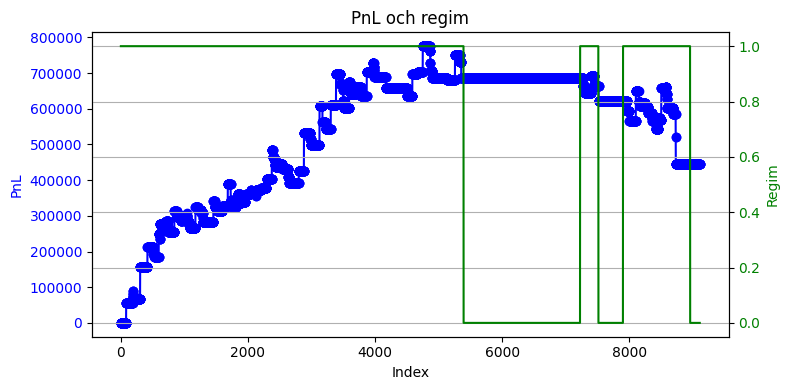

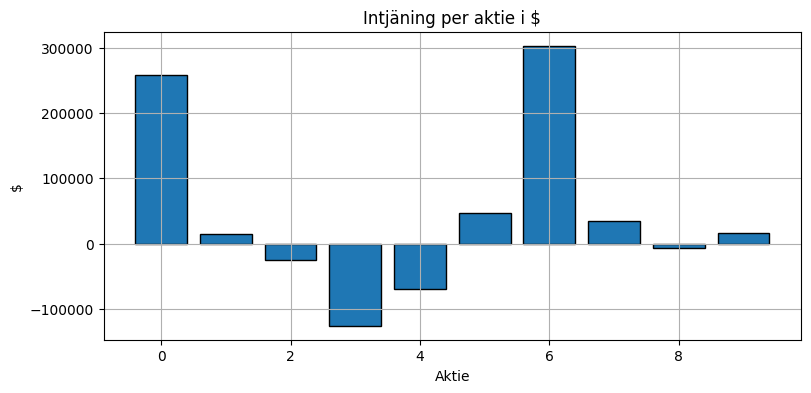

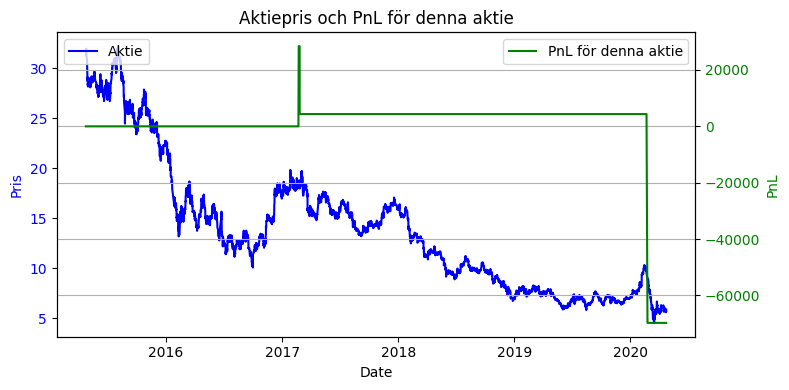

In [24]:
# 2: Plottar resultat och performancedata

# Beräknar perfomancedata
row_sums = np.sum(PnL_matrix, axis=1)
result_overTime = np.cumsum(row_sums)
tot_result = result_overTime[-1]
tot_perf = (tot_result/start_capital)*100
column_sums = np.sum(PnL_matrix, axis=0)
number_days = len(result_overTime)
number_years = number_days/(252*8)
tot_cagr = ((1+(tot_perf/100))**(1/number_years)-1)*100
num_winTrades = len(nr_profit_trades)
num_lossTrades = len(nr_loss_trades)
tot_trades = num_winTrades+num_lossTrades
win_prob = (num_winTrades/tot_trades)*100
loss_prob = (num_lossTrades/tot_trades)*100
mean_profit = np.mean(avr_profit_trades)*100
mean_loss = np.mean(avr_loss_trades)*100
win_loss_ratio = mean_profit/abs(mean_loss)
tot_all_perf = np.zeros(hist_stocks)

# Jämförelse med allaaktier viktat
for i in range(hist_stocks):
    start_price = all_EOD_data.iloc[0,1+4*i]
    end_price = all_EOD_data.iloc[-1,1+4*i]  
    tot_all_perf[i] = (end_price/start_price)-1

market_return = np.mean(tot_all_perf)*100

# Printar ut all performancedata
print("*SAMMANSTÄLLNING*")
print(f"Totalavkastning för strategin: {tot_perf:.2f}%")
print(f"Totalavkastning för marknaden: {market_return:.2f}%")
print(f"Genomsnittlig årlig avkastning för strategin: {tot_cagr:.2f}%")
print(f"Antal vinsttrades: {num_winTrades:.0f}")
print(f"Antal förlusttrades: {num_lossTrades:.0f}")
print(f"Vinstsannolikhet: {win_prob:.2f}%")
print(f"Förlustsannolikhet: {loss_prob:.2f}%")
print(f"Genomsnittlig vinsttrade: {mean_profit:.2f}%")
print(f"Genomsnittlig förlusttrade: {mean_loss:.2f}%")
print(f"Vinst/förlust-ratio: {win_loss_ratio:.2f}")

# Plottar avkastning över tid
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(result_overTime[save_index:], marker='o', linestyle='-', color='b', label='PnL')
ax1.set_xlabel('Index')
ax1.set_ylabel('PnL', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(market_regim, linestyle='-', color='g', label='Regim')
ax2.set_ylabel('Regim', color='g')
ax2.tick_params(axis='y', labelcolor='g')
plt.title('PnL och regim')
fig.tight_layout()
plt.grid(True)
plt.show()

# Plottar total intjäning per aktie
plt.figure(figsize=(9,4))
plt.bar(range(len(column_sums)), column_sums, edgecolor='black')
plt.xlabel('Aktie')
plt.ylabel('$')
plt.title('Intjäning per aktie i $')
plt.grid(True)
plt.show()

# Plottar EOD-datan för valfri aktie
# NEDAN: "kolumn 0" till "kolumn 9" (för 10 aktier)
cumsum_column_1 = np.cumsum(PnL_matrix[:,4])
fig, ax1 = plt.subplots(figsize=(8,4))
# NEDAN: "hour_close" till "hour_close_9" (för 10 aktier)
ax1.plot(all_1h_data['date'], all_1h_data['hour_close_4'], label='Aktie', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Pris', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(all_1h_data['date'], cumsum_column_1, label='PnL för denna aktie', color='g')
ax2.set_ylabel('PnL', color='g')
ax2.tick_params(axis='y', labelcolor='g')
plt.title('Aktiepris och PnL för denna aktie')
fig.tight_layout()
plt.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

In [25]:
# DEL 3: STRATEGI 2 - Gap_n_Go_undMom

In [ ]:
# 1: Backtestar strategi 1: Gap_n_Go_undMom

# Initierar variabler
hist_stocks = num_stocks
cash_capital = 1000000
start_capital = cash_capital
barrier_capital = cash_capital
holding_period = 8*10 #10
cool_down_period = 8*10 #10

current_position = np.zeros(hist_stocks) # 1x10 vektor: 1 om en position finns, 0 annars
current_time = np.zeros(hist_stocks) # 1x10 vektor: senaste indexet för när ett köp gjordes
cant_buy_timer = np.zeros(hist_stocks) # 1x10 vektor: här sparas indexet för då senaste stoppen togs
last_payed = np.zeros(hist_stocks) # 1x10 vektor: dummy-vektor för senaste priset
buy_price = np.zeros(hist_stocks) # 1x10 vektor: senaste priset för när ett köp gjordes
sell_price = np.zeros(hist_stocks) # 1x10 vektor: senaste priset för när ett sälj gjordes
number_stocks = np.zeros(hist_stocks) # 1x10 vektor: antalet aktier vi äger i en enskild aktie

PnL_matrix = np.zeros((len(all_1h_data),hist_stocks))
market_regim = []
nr_loss_trades = []
nr_profit_trades = []
avr_loss_trades = []
avr_profit_trades = []

# Tar fram startvärde
all_1h_data['date'] = pd.to_datetime(all_1h_data['date'])
start_date = pd.to_datetime(all_EOD_data['date'].iloc[0]).normalize()
matching_rows = all_1h_data[all_1h_data['date'].dt.normalize() == start_date]
start_index = matching_rows.index.min()
save_index = start_index

print("Backtesting, trade log:")

# Kör igenom i tissteget
for index in range(start_index, len(all_1h_data)): 

    # Tar fram gårdagens datum och mapar mot EOD-datan
    previous_date = pd.to_datetime(all_1h_data['date'].iloc[index-9]).normalize()
    previous_EOD_row = all_EOD_data[all_EOD_data['date'].dt.normalize() == previous_date]

    stock_counter = 0
    
    # Regimfilter
    for i in range(hist_stocks):
        
        previous_EOD_price = previous_EOD_row.iloc[0,1+4*i]
        previous_EOD_MA63 = previous_EOD_row.iloc[0,2+4*i]
        previous_EOD_MA252 = previous_EOD_row.iloc[0,3+4*i]

        if previous_EOD_MA63 > previous_EOD_MA252:
            stock_counter = stock_counter+1

    market_breadth = stock_counter/hist_stocks
    regim_condition = 0.4 # 0.4

    if market_breadth >= regim_condition:
        market_regim.append(1)
        current_regim = 1
    else:
        market_regim.append(0)
        current_regim = 0
    
    number_trades = 0
    add_cash = np.zeros(hist_stocks)

    # Kör igenom varje aktie för samma tidssteg
    for i in range(hist_stocks):

        # För underliggande momentumvillkor
        previous_EOD_price = previous_EOD_row.iloc[0,1+4*i]
        previous_EOD_MA63 = previous_EOD_row.iloc[0,2+4*i]
        previous_EOD_MA252 = previous_EOD_row.iloc[0,3+4*i]
        previous_EOD_STD63 = previous_EOD_row.iloc[0,4+4*i]

        # För köpvillkor
        current_1h_price = all_1h_data.iloc[index,1+2*i]
        current_time = all_1h_data.iloc[i,0].time()
        target_time = time(15, 0, 0)
    
        # Justerbara värden
        std_threshold = 1.0 # 1.0

        # Köpvillkor
        # Gap ner större än 1,5 STD (senaste 08:00 priset för dagens datum)
        # Mindre än 0,5 STD från gårdagens close (denna har jag allt)
        if current_regim == 1 and current_position[i] == 0 and current_time == target_time and previous_EOD_price > previous_EOD_MA63 and previous_EOD_MA63 > previous_EOD_MA252:
            current_time[i] = index
            last_payed[i] = current_1h_price
            number_trades = number_trades+1
            
        # Risk management-sälj
        elif current_position[i] == 1 and (current_1h_price/buy_price[i])-1 < -std_threshold*previous_EOD_STD63:
            PnL_matrix[index,i] = (current_1h_price-buy_price[i])*number_stocks[i]
            add_cash[i] = current_1h_price*number_stocks[i]
            sell_amount = current_1h_price*number_stocks[i]
            date_object = pd.to_datetime(all_1h_data['date'].iloc[index])
            print(f"Risk management: Sold for {sell_amount:.0f}$ in stock_{i} for price {current_1h_price:.2f} at time {date_object} with {index}")
            number_stocks[i] = 0
            current_position[i] = 0
            cant_buy_timer[i] = index
            nr_loss_trades.append(1)
            avr_loss_trades.append(current_1h_price/buy_price[i]-1)

        # Vinsthemtagning-sälj
        elif current_position[i] == 1 and index-current_time[i] > holding_period:
            PnL_matrix[index,i] = (current_1h_price-buy_price[i])*number_stocks[i]
            add_cash[i] = current_1h_price*number_stocks[i]
            sell_amount = current_1h_price*number_stocks[i]
            date_object = pd.to_datetime(all_1h_data['date'].iloc[index])
            print(f"Profit-taking: Sold for {sell_amount:.0f}$ in stock_{i} for price {current_1h_price:.2f} at time {date_object} with {index}")
            number_stocks[i] = 0
            current_position[i] = 0
            nr_profit_trades.append(1)
            avr_profit_trades.append(current_1h_price/buy_price[i]-1)
            
    if cash_capital > 0.01*barrier_capital and number_trades > 0:
        bet_size = cash_capital/number_trades
        for i in range(hist_stocks):
            if current_time[i] == index:
                buy_price[i] = last_payed[i]
                number_stocks[i] = bet_size/buy_price[i]
                current_position[i] = 1
                date_object = pd.to_datetime(all_1h_data['date'].iloc[index])
                print(f"Bought for {bet_size:.0f}$ in stock_{i} for price {buy_price[i]:.2f} at time {date_object} with {index}")
        cash_capital = 0  
        
    cash_capital = cash_capital+sum(add_cash)

Backtesting, trade log:
15:00:00
14:00:00
Bought for 500000$ in stock_0 for price 110.23 at time 2016-05-13 07:00:00 with 2362
Bought for 500000$ in stock_8 for price 92.27 at time 2016-05-13 07:00:00 with 2362
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:00
12:00:00
13:00:

*SAMMANSTÄLLNING*
Totalavkastning för strategin: -15.38%
Totalavkastning för marknaden: -7.12%
Genomsnittlig årlig avkastning för strategin: -2.89%
Antal vinsttrades: 224
Antal förlusttrades: 438
Vinstsannolikhet: 33.84%
Förlustsannolikhet: 66.16%
Genomsnittlig vinsttrade: 3.54%
Genomsnittlig förlusttrade: -1.68%
Vinst/förlust-ratio: 2.11


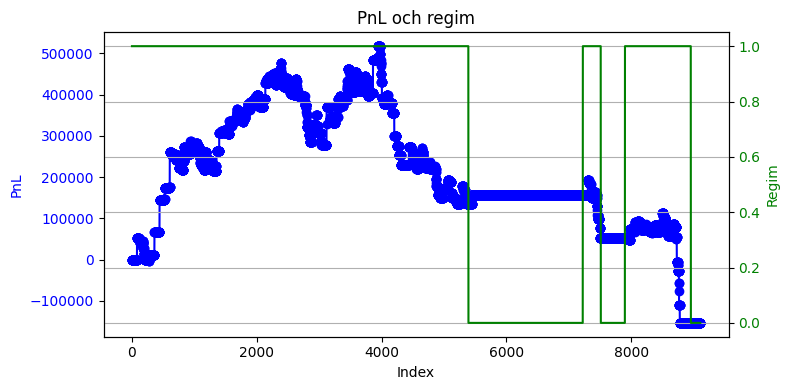

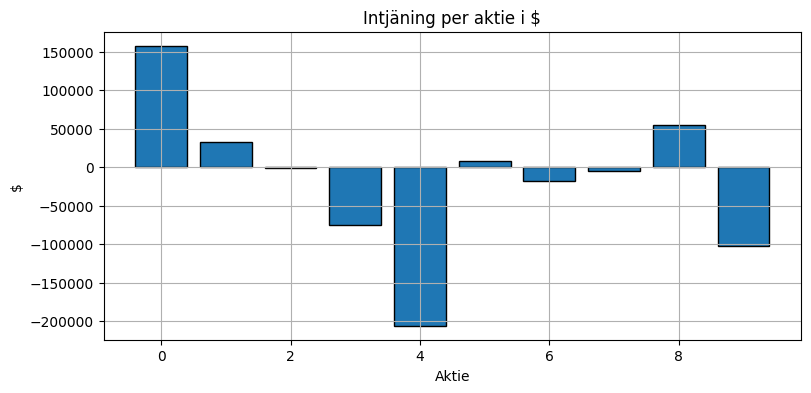

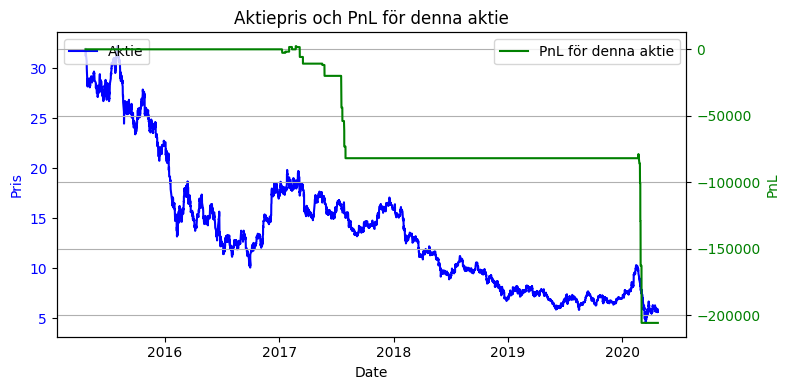

In [33]:
# 2: Plottar resultat och performancedata

# Beräknar perfomancedata
row_sums = np.sum(PnL_matrix, axis=1)
result_overTime = np.cumsum(row_sums)
tot_result = result_overTime[-1]
tot_perf = (tot_result/start_capital)*100
column_sums = np.sum(PnL_matrix, axis=0)
number_days = len(result_overTime)
number_years = number_days/(252*8)
tot_cagr = ((1+(tot_perf/100))**(1/number_years)-1)*100
num_winTrades = len(nr_profit_trades)
num_lossTrades = len(nr_loss_trades)
tot_trades = num_winTrades+num_lossTrades
win_prob = (num_winTrades/tot_trades)*100
loss_prob = (num_lossTrades/tot_trades)*100
mean_profit = np.mean(avr_profit_trades)*100
mean_loss = np.mean(avr_loss_trades)*100
win_loss_ratio = mean_profit/abs(mean_loss)
tot_all_perf = np.zeros(hist_stocks)

# Jämförelse med allaaktier viktat
for i in range(hist_stocks):
    start_price = all_EOD_data.iloc[0,1+4*i]
    end_price = all_EOD_data.iloc[-1,1+4*i]  
    tot_all_perf[i] = (end_price/start_price)-1

market_return = np.mean(tot_all_perf)*100

# Printar ut all performancedata
print("*SAMMANSTÄLLNING*")
print(f"Totalavkastning för strategin: {tot_perf:.2f}%")
print(f"Totalavkastning för marknaden: {market_return:.2f}%")
print(f"Genomsnittlig årlig avkastning för strategin: {tot_cagr:.2f}%")
print(f"Antal vinsttrades: {num_winTrades:.0f}")
print(f"Antal förlusttrades: {num_lossTrades:.0f}")
print(f"Vinstsannolikhet: {win_prob:.2f}%")
print(f"Förlustsannolikhet: {loss_prob:.2f}%")
print(f"Genomsnittlig vinsttrade: {mean_profit:.2f}%")
print(f"Genomsnittlig förlusttrade: {mean_loss:.2f}%")
print(f"Vinst/förlust-ratio: {win_loss_ratio:.2f}")

# Plottar avkastning över tid
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(result_overTime[save_index:], marker='o', linestyle='-', color='b', label='PnL')
ax1.set_xlabel('Index')
ax1.set_ylabel('PnL', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(market_regim, linestyle='-', color='g', label='Regim')
ax2.set_ylabel('Regim', color='g')
ax2.tick_params(axis='y', labelcolor='g')
plt.title('PnL och regim')
fig.tight_layout()
plt.grid(True)
plt.show()

# Plottar total intjäning per aktie
plt.figure(figsize=(9,4))
plt.bar(range(len(column_sums)), column_sums, edgecolor='black')
plt.xlabel('Aktie')
plt.ylabel('$')
plt.title('Intjäning per aktie i $')
plt.grid(True)
plt.show()

# Plottar EOD-datan för valfri aktie
# NEDAN: "kolumn 0" till "kolumn 9" (för 10 aktier)
cumsum_column_1 = np.cumsum(PnL_matrix[:,4])
fig, ax1 = plt.subplots(figsize=(8,4))
# NEDAN: "hour_close" till "hour_close_9" (för 10 aktier)
ax1.plot(all_1h_data['date'], all_1h_data['hour_close_4'], label='Aktie', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Pris', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(all_1h_data['date'], cumsum_column_1, label='PnL för denna aktie', color='g')
ax2.set_ylabel('PnL', color='g')
ax2.tick_params(axis='y', labelcolor='g')
plt.title('Aktiepris och PnL för denna aktie')
fig.tight_layout()
plt.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()